In [11]:
import scipy.io as scio
import h5py
import tifffile as tf
from PIL import Image

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from scipy.stats import pearsonr
import networkx as nx
from networkx.algorithms import community
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import itertools
from itertools import chain

## Settings and Parameters

In [12]:
## parameters
data_index = 'xxxx' # for example '20230417-fly2'
date_id = 'xxxx' # for example '20230417'
fly_id = 'xxxx' # for example 'fly2'
n_trails = 180

data_index_list = ['20230417-fly2', '20230420-fly2', '20230420-fly3', '20230428-fly1', '20230507-fly1', '20230510-fly1',
                   '20230510-fly2', '20230511-fly2', '20230511-fly3', '20230515-fly1']
focus_regions_0 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,82,85,67] # all brain regions
focus_regions_1 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,85,67] # brain regions except 80,82,
focus_regions_2 = [64,65,66,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,85,67] # brain regions except 55,80,82,

## path
path = 'xxxx/data/Ach/'+ data_index + '/'
path_atlas  = 'xxxx/data/Ach/'+ data_index + '/align_to_atlas/'
path_output = '../result/flies_ACh/ACh-'+ data_index + '-trans-stimu/'

## Load data

In [3]:
'''
Load G7f data

Data description: dff0_con_C3 is 180 trails * 23 timepoints * 25 * 256 * 256 (z,x,y)
'''

dff0_con_C3 = np.load(path + 'dff0_-3-20_down1_C3.npy') 

print(type(dff0_con_C3), dff0_con_C3.shape)

<class 'numpy.ndarray'> (180, 23, 25, 256, 256)


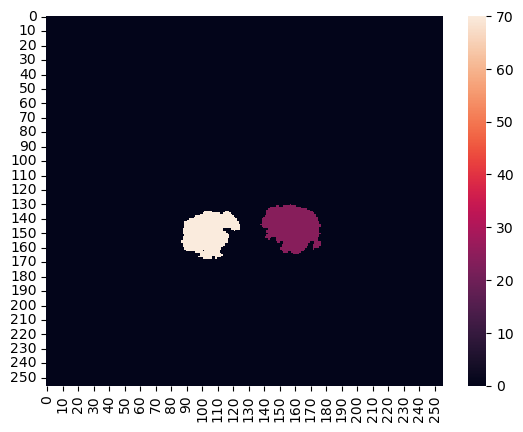

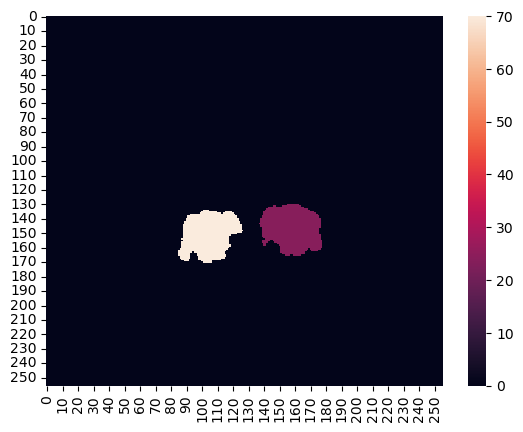

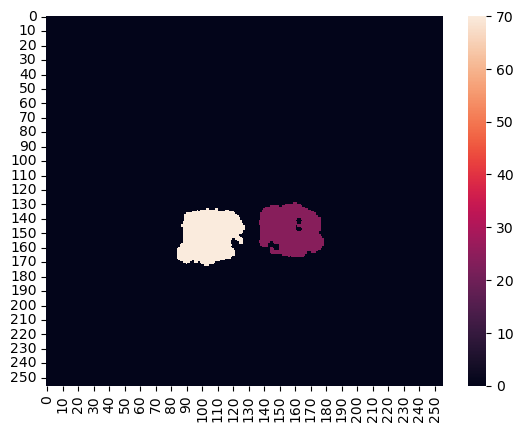

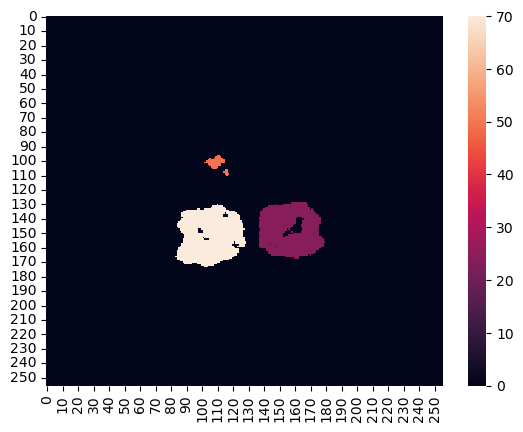

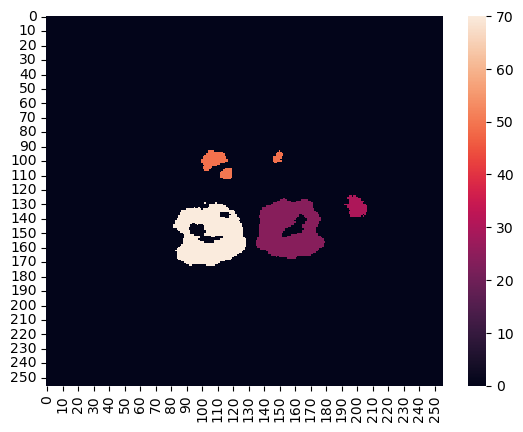

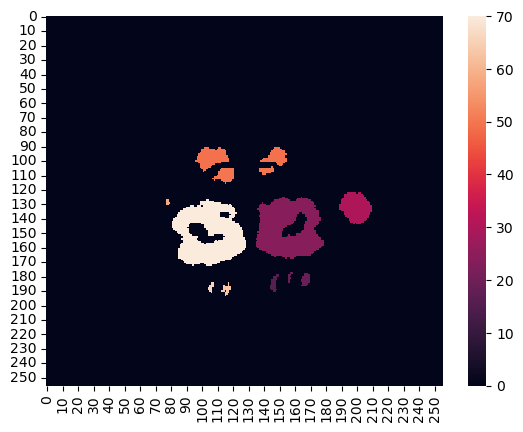

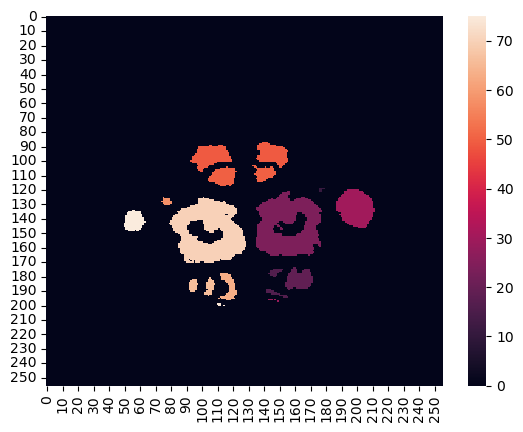

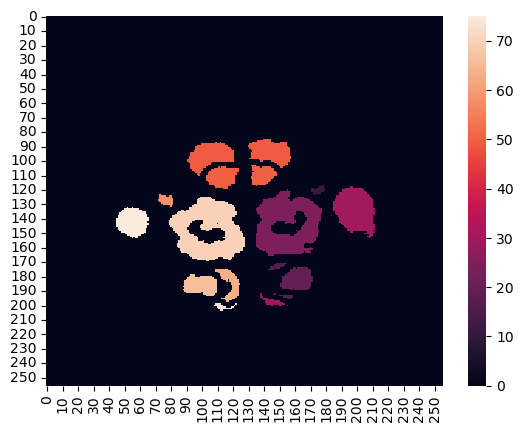

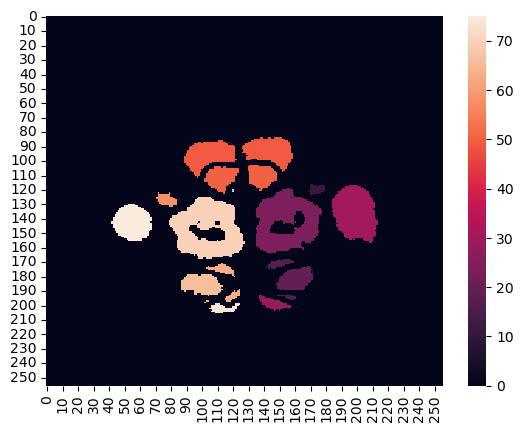

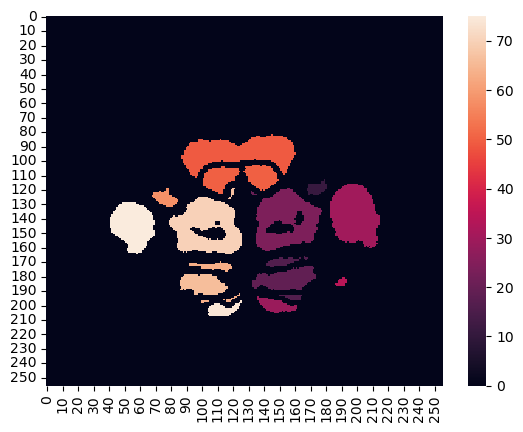

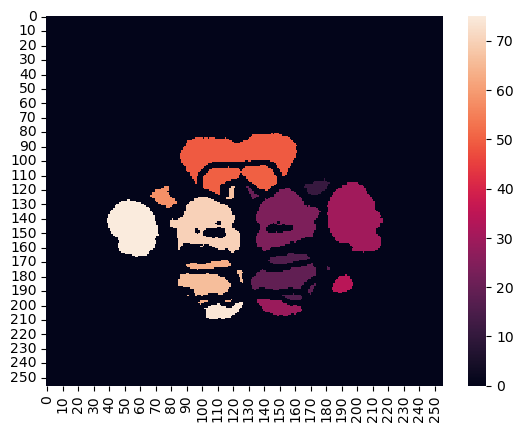

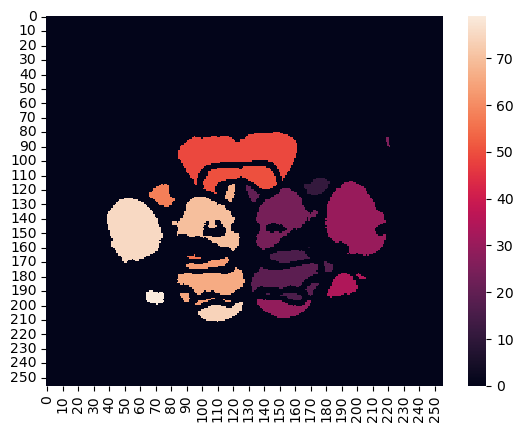

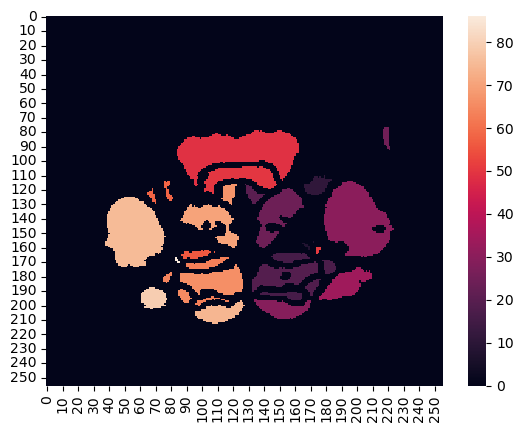

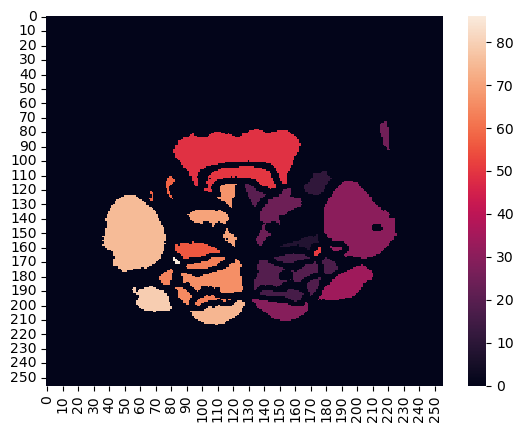

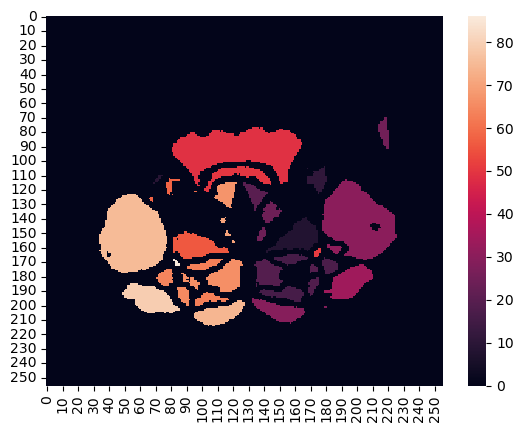

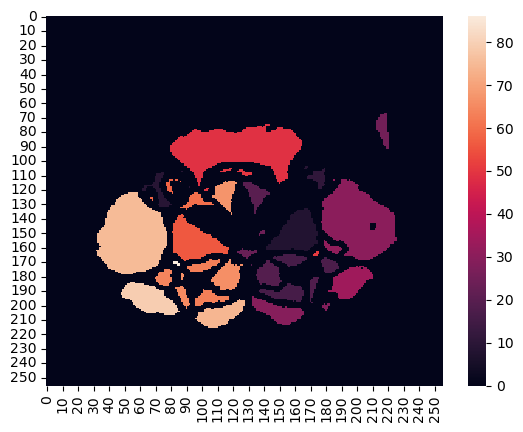

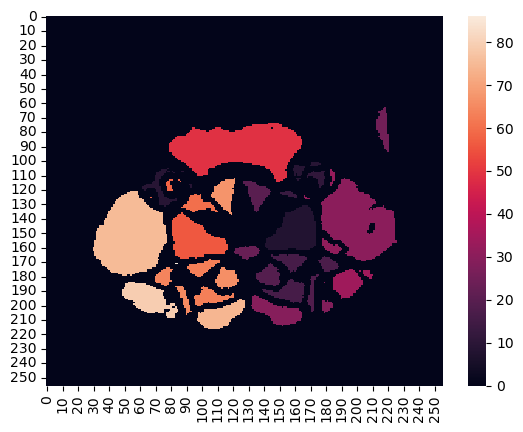

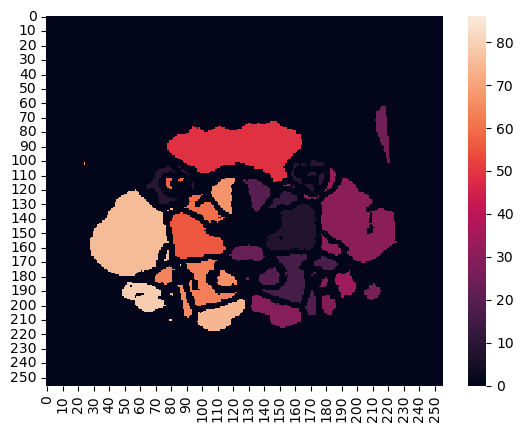

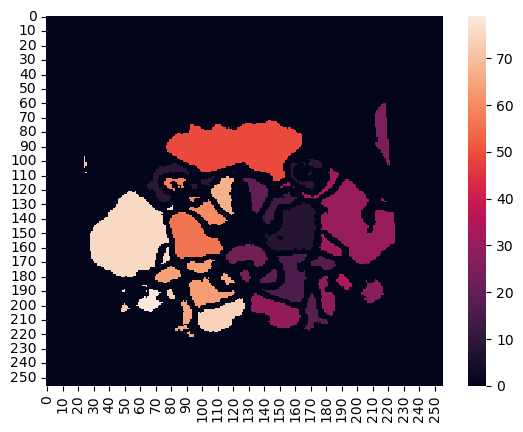

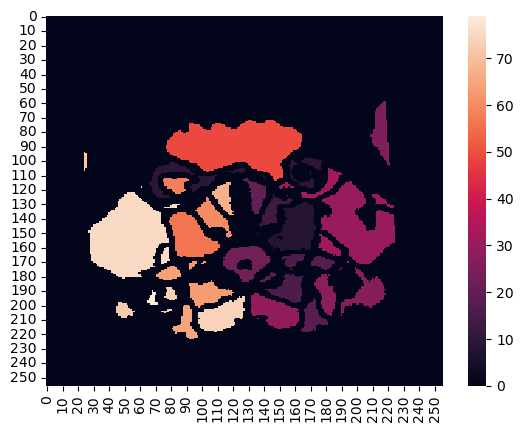

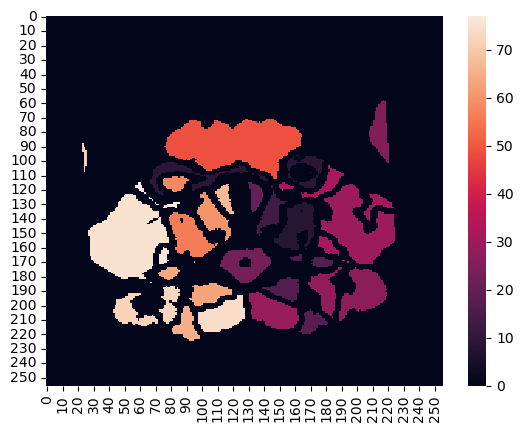

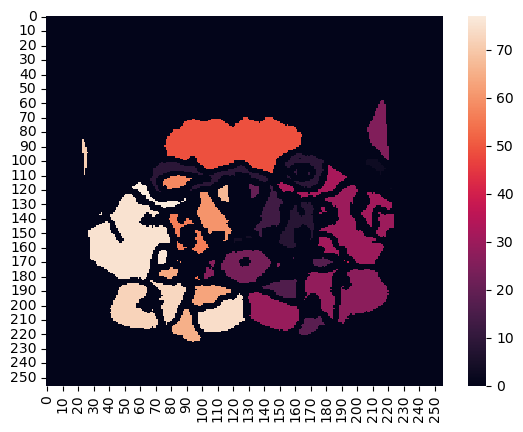

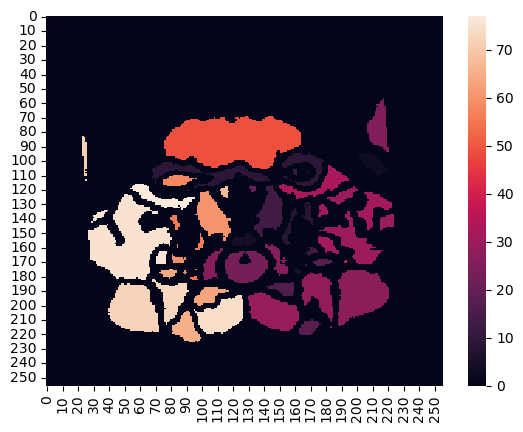

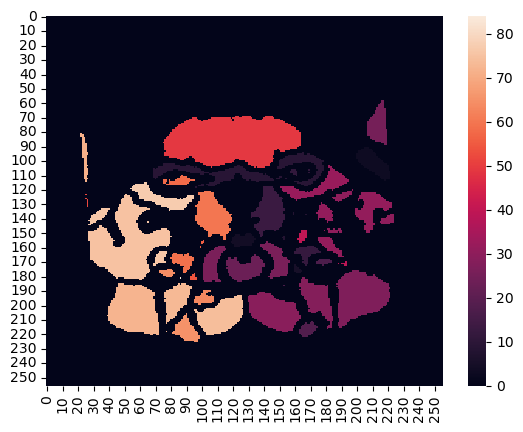

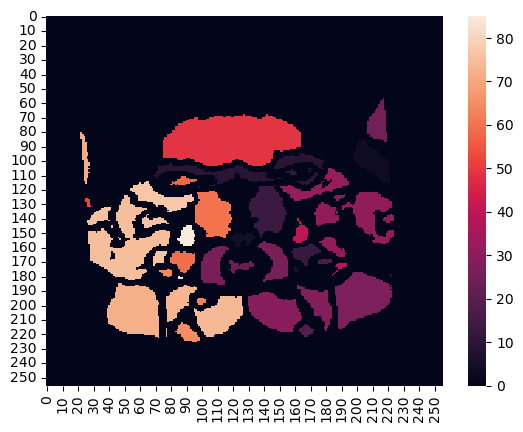

# region indices:  54  region indices:  [2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 39, 40, 49, 50, 51, 52, 54, 56, 58, 59, 60, 63, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 79, 84, 85, 86]


In [4]:
'''
Load atlas 
'''

## load atlas data
image_file = path_atlas + 'Transformed_atlas_eroded_r5.tif'
img_tf = tf.imread(image_file)

## list the brain region indices
region_idx = []
for i in range(13,38): # only need the 13th - 38th layers of atlas
    non_val = img_tf[i].ravel()[np.flatnonzero(img_tf[i])].tolist()
    region_idx += list(set(non_val))
    ## plot atlas
    data = pd.DataFrame(img_tf[i])
    sns.heatmap(data)
    plt.show()
region_idx = list(set(region_idx))

print("# region indices: ", len(region_idx), " region indices: ", region_idx)

## Concatenate ACh recordings

In [6]:
## Splicing multiple sessions for each neuron
for region_idx in focus_regions_0:
    ## save the neuron positions of each region
    neurons_positions = {}    
    for i in range(13,38):
        x_idx, y_idx = np.where(img_tf[i] == region_idx)
        if len(x_idx) > 0 and len(y_idx) > 0:
            neurons_positions[i] = [(x_idx[j], y_idx[j]) for j in range(len(x_idx))]
    np.save(path_output + 'neuron_concat_records/region_' + str(region_idx) + '_neuron_positions.npy', neurons_positions)
    print('region_' + str(region_idx) + ' save neuron positions!')
    
    ## save the neuron G7f records of each region
    neuron_records = []
    for k,v in neurons_positions.items():
        z = k - 13
        for x_y in v:
            neuron_record = []
            for i in range(n_trails):                
                neuron_record += list(dff0_con_C3[i, :, z, x_y[0], x_y[1]]) 
            neuron_records.append(neuron_record)
    np.save(path_output + 'neuron_concat_records/region_' + str(region_idx) + '_neuron_records.npy', neuron_records)
    if len(neuron_records) == 0:
        print('neuron records: ', 0, 0)
    else:
        print('neuron records: ', len(neuron_records),len(neuron_records[0]))
    
    del neuron_records 
    del neurons_positions

print('END')

region_64 save neuron positions!
neuron records:  963 4140
region_65 save neuron positions!
neuron records:  1713 4140
region_66 save neuron positions!
neuron records:  3841 4140
region_55 save neuron positions!
neuron records:  0 0
region_72 save neuron positions!
neuron records:  3777 4140
region_73 save neuron positions!
neuron records:  1486 4140
region_74 save neuron positions!
neuron records:  6204 4140
region_63 save neuron positions!
neuron records:  3756 4140
region_84 save neuron positions!
neuron records:  5 4140
region_59 save neuron positions!
neuron records:  326 4140
region_4 save neuron positions!
neuron records:  319 4140
region_23 save neuron positions!
neuron records:  2912 4140
region_26 save neuron positions!
neuron records:  1386 4140
region_56 save neuron positions!
neuron records:  4886 4140
region_79 save neuron positions!
neuron records:  2630 4140
region_75 save neuron positions!
neuron records:  26840 4140
region_76 save neuron positions!
neuron records:  66

## Generate the brain-region-level  functional connectivity network

---- processing region  64  ----
G7f data: 963 4140
selected data: 963 3600
---- processing region  65  ----
G7f data: 1713 4140
selected data: 1713 3600
---- processing region  66  ----
G7f data: 3841 4140
selected data: 3841 3600
---- processing region  72  ----
G7f data: 3777 4140
selected data: 3777 3600
---- processing region  73  ----
G7f data: 1486 4140
selected data: 1486 3600
---- processing region  74  ----
G7f data: 6204 4140
selected data: 6204 3600
---- processing region  63  ----
G7f data: 3756 4140
selected data: 3756 3600
---- processing region  84  ----
G7f data: 5 4140
selected data: 5 3600
---- processing region  59  ----
G7f data: 326 4140
selected data: 326 3600
---- processing region  4  ----
G7f data: 319 4140
selected data: 319 3600
---- processing region  23  ----
G7f data: 2912 4140
selected data: 2912 3600
---- processing region  26  ----
G7f data: 1386 4140
selected data: 1386 3600
---- processing region  56  ----
G7f data: 4886 4140
selected data: 4886 3600

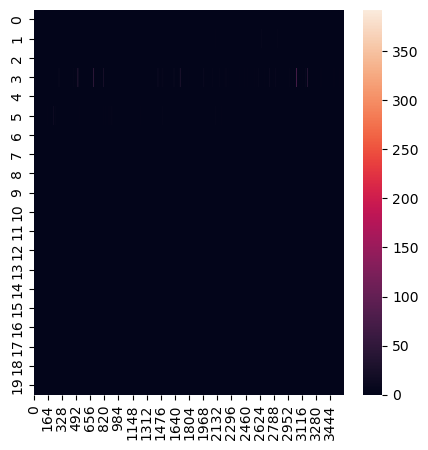

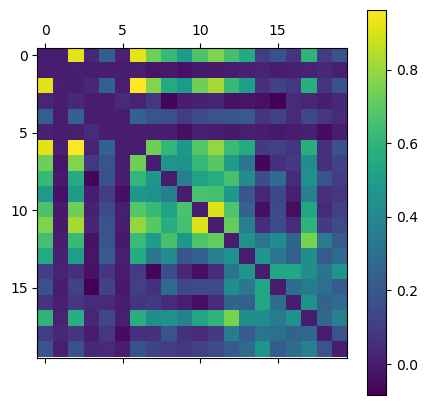

# original edges: 400  # preserved edges: 140
# node: 20  # edges: 140


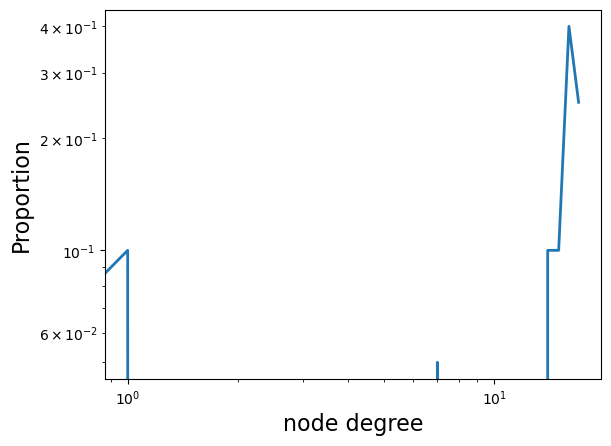

END


In [8]:
focus_regions = []
## Some brain regions of the specified flies are not used
if data_index in ['20230428-fly1', '20230510-fly1']:
    focus_regions = focus_regions_1
elif data_index == '20230507-fly1':
    focus_regions = focus_regions_2
else:
    focus_regions = focus_regions_0

'''
average neuron recordings for each region
'''
region_records_avg = []
for region_idx in focus_regions:
    print("---- processing region ", region_idx, " ----")

    ## load record data
    records = np.load(path_output +'neuron_concat_records/region_' + str(region_idx) + '_neuron_records.npy',allow_pickle=True)
    print("G7f data:", len(records), len(records[0]))
    
    ## select records for the given time period
    select_data = records[:, 3 : 23]
    frames = 20 
    duration = 23
    start_timepoint = 3 + duration
    len_max = len(records[0])
    while start_timepoint < len_max:
        select_data = np.concatenate((select_data,records[:, start_timepoint : start_timepoint + frames]), axis = 1) 
        start_timepoint += duration
    print("selected data:", len(select_data), len(select_data[0]))
    
    ## generate average records
    select_data_avg = np.mean(select_data, axis = 0)
    region_records_avg.append(select_data_avg)
    
## plot average records
figure = plt.figure(figsize=(5,5)) 
data = pd.DataFrame(region_records_avg)
sns.heatmap(data)
plt.savefig(path_output + 'network/whole_brain_all_regions_records.png', dpi = 300, bbox_inches='tight')
plt.show()

'''
generate functional connectivity matrix
'''

## calculate pearson correlation matrix
data_list = []
n_neurons = len(region_records_avg)
similarity = np.zeros((n_neurons, n_neurons))
for i in range(n_neurons - 1):
    for j in range(i + 1, n_neurons):   
        pearson = pearsonr(region_records_avg[i], region_records_avg[j])
        similarity[i][j] = similarity[j][i] = pearson[0]
similarity = np.nan_to_num(similarity)
np.save(path_output + 'network/whole_brain_all_regions_similarity.npy', similarity)

## plot correlation matrix
figure = plt.figure(figsize=(5,5)) 
axes = figure.add_subplot(111) 
caxes = axes.matshow(similarity, interpolation ='nearest') 
figure.colorbar(caxes) 
plt.savefig(path_output + 'network/whole_brain_all_regions_similarity.png', dpi = 300, bbox_inches='tight')
plt.show()

'''
generate functional connectivity network
'''

## keep only correlations with high positive values 
delete_seg = 0.3
weighted_edges_list = similarity.flatten()
weighted_edges_list.sort()
threshold = weighted_edges_list[int(delete_seg * len(weighted_edges_list))]

## generate network from correlation matrix
nodes = [i for i in range(len(focus_regions_0)) if focus_regions_0[i] in focus_regions]
weighted_edges = [] 
source = []
target = []
weight = []
for i in range(n_neurons - 1):
    for j in range(i + 1, n_neurons):
        x, y = nodes[i], nodes[j]
        v = similarity[i,j]
        if v < threshold:
            continue
        weighted_edges.append(np.array([x, y, np.round(v,4)]))
        source.append(x)
        target.append(y)
        weight.append(np.round(v,4))
print("# original edges:", len(weighted_edges_list), " # preserved edges:", len(weighted_edges))

## save network into csv files
save_data_calc = {"source": source, "target": target, "weight": weight}
df = pd.DataFrame(save_data_calc)
df.to_csv(path_output + 'network/regions_of_whole_brain_network_edges' + str(round(1 - delete_seg, 1)) + '.csv', index=False)

'''
calculate network statistics
'''

## generate network
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(weighted_edges)

## network statistics
n_nodes, n_edges = G.number_of_nodes(),G.number_of_edges()
print("# node:",n_nodes, " # edges:", n_edges)
degrees = nx.degree_histogram(G)
x = range(len(degrees))
y = [z / float(sum(degrees)) for z in degrees]
plt.loglog(x,y, linewidth = 2)
plt.xlabel("node degree", fontdict={'size': 16})
plt.ylabel("Proportion", fontdict={'size': 16})
plt.show()

degree_assortativity = nx.degree_assortativity_coefficient(G)
avg_clustering = nx.average_clustering(G)
avg_shortest_path = 0
diameter = 0
try:
    avg_shortest_path = nx.average_shortest_path_length(G)
    diameter = nx.diameter(G)
except:
    print('G is not connected!')
density = nx.density(G)
transitivity = nx.transitivity(G)
d = dict(nx.degree(G))
avg_degree = sum(d.values())/G.number_of_nodes()

node_degrees = [round(i[1],3) for i in nx.degree(G,weight="weight")]
node_degrees_avg = np.mean(node_degrees)

degree_centrality = [round(i,3) for i in nx.degree_centrality(G).values()]
degree_centrality_avg = np.mean(degree_centrality)

closeness_centrality = [round(i,3) for i in nx.closeness_centrality(G).values()]
closeness_centrality_avg = np.mean(closeness_centrality)

betweenness_centrality = [round(i,3) for i in nx.betweenness_centrality(G).values()]
betweenness_centrality_avg = np.mean(betweenness_centrality)

louvain_communities_comm = community.louvain_communities(G, weight='weight')  
louvain_communities_mod = community.modularity(G, louvain_communities_comm)

greedy_modularity_communities_comm = community.greedy_modularity_communities(G, weight='weight')  
greedy_modularity_communities_mod = community.modularity(G, greedy_modularity_communities_comm)

# save network statistics into csv files 
writer = pd.ExcelWriter(path_output +'network_stat/regions_of_whole_brain_network_edges' + str(round(1 - delete_seg, 1)) + '_stat.xlsx')  
data_dict = {}
data_dict["stats"] = ["nodes", "edges", "degree_assortativity", "avg_clustering", "avg_shortest_path", "density", "diameter", 
                      "transitivity", "avg_degree","n_degrees_mean", "n_degrees_mean_avg", "n_avg_degree_centrality", 
                      "n_avg_closeness_centrality", "n_avg_betweenness_centrality","n_degrees", "n_degree_centrality", 
                      "n_closeness_centrality",  "n_betweenness_centrality", "louvain_modulairty", "greedy_modularity"]
data_dict["values"] = [n_nodes, n_edges, round(degree_assortativity,3),round(avg_clustering,3),round(avg_shortest_path,3), round(density,3),
                    diameter, round(transitivity,3), round(avg_degree,3),
                    node_degrees_avg, round(node_degrees_avg/n_nodes,3), degree_centrality_avg,
                    closeness_centrality_avg, betweenness_centrality_avg, 
                    node_degrees, degree_centrality, closeness_centrality, betweenness_centrality,
                    louvain_communities_mod, greedy_modularity_communities_mod]
df = pd.DataFrame(data_dict)
df.to_excel(writer, sheet_name = "stat", index = False)        
writer.save()

print("END")

## Generate the functional connectivity network for each region

---- processing region  85  ----
G7f data: 114 4140
selected data: 114 3600


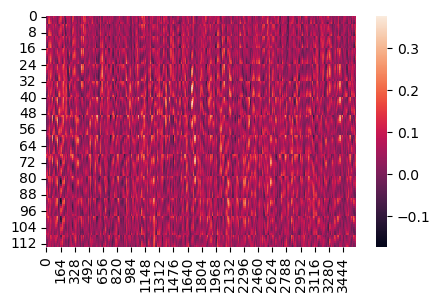

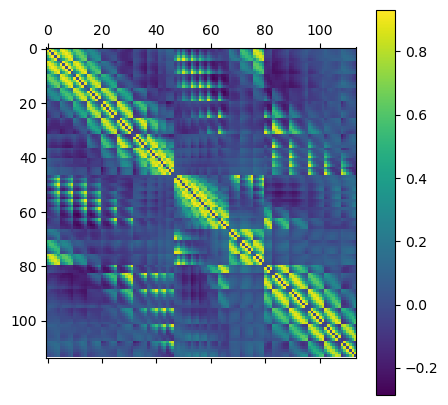

Successfully saving similarity matrix!
# original edges: 6441  # preserved edges: 2577
# node: 114  # edges: 2577
END


C:\Users\BBNC\AppData\Local\Temp\ipykernel_13164\4143924278.py:170: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [13]:
focus_regions = []
## Some brain regions of the specified flies are not used
if data_index in ['20230428-fly1', '20230510-fly1']:
    focus_regions = focus_regions_1
elif data_index == '20230507-fly1':
    focus_regions = focus_regions_2
else:
    focus_regions = focus_regions_0

## generate network for each region
for region_idx in [85]: #[64,65,66,73,63,84,59,23,26,55,85,79,77]:   
    print("---- processing region ", region_idx, " ----")
    
    if region_idx not in focus_regions:
        continue
    
    '''
    load data
    '''
    
    ## load G7f data
    records = np.load(path_output + 'neuron_concat_records/region_' + str(region_idx) + '_neuron_records.npy',allow_pickle=True)
    print("G7f data:", len(records), len(records[0]))
    
    ## select records for the given time period
    select_data = records[:, 3 : 23]
    frames = 20 
    duration = 23
    start_timepoint = 3 + duration
    len_max = len(records[0])
    while start_timepoint < len_max:
        select_data = np.concatenate((select_data,records[:, start_timepoint : start_timepoint + frames]), axis = 1) 
        start_timepoint += duration
    print("selected data:", len(select_data), len(select_data[0]))
    np.save(path_output + 'network/region_' + str(region_idx) + '_all_neurons_records.npy', select_data)
       
    ## plot selected data
    figure = plt.figure(figsize=(5,3)) 
    data = pd.DataFrame(select_data)
    sns.heatmap(data)
    plt.savefig(path_output + 'network/region_' + str(region_idx) + '_all_neurons_records.png', dpi = 300, bbox_inches='tight')
    plt.show()
    
    '''
    generate functional connectivity matrix
    '''
    
    ## calculate pearson correlation
    region_similarity_dict = {}
    n_neurons = len(select_data)
    for i in range(n_neurons - 1):
        for j in range(i + 1, n_neurons):   
            pearson = pearsonr(select_data[i], select_data[j])
            region_similarity_dict[(i,j)] = pearson[0]         
    
    ## calculate hierarchy clustering
    Z = linkage(select_data, 'ward') 
    k = 4
    clusters = fcluster(Z, k, criterion='maxclust')
    list(enumerate(clusters))
    hierarchy_idx = []
    for index_id in range(1,k+1):
        index = [i for i,j in enumerate(clusters) if j == index_id]
        hierarchy_idx.append(index)   
    hierarchy_idx_list = list(chain(*hierarchy_idx))
    
    ## calculate hierarchy correlation
    similarity = np.zeros((n_neurons, n_neurons))
    for i in range(n_neurons - 1):
        for j in range(i + 1, n_neurons):   
            pair = (hierarchy_idx_list[i],hierarchy_idx_list[j])
            if pair not in region_similarity_dict.keys():
                pair = (hierarchy_idx_list[j],hierarchy_idx_list[i])
            similarity[i,j] = similarity[j,i] = np.mean(region_similarity_dict[pair])
            
    ## plot correlation
    figure = plt.figure(figsize=(5,5))
    axes = figure.add_subplot(111) 
    caxes = axes.matshow(similarity, interpolation ='nearest') 
    figure.colorbar(caxes) 
    plt.savefig(path_output + 'network/region_' + str(region_idx) + '_all_neurons_similarity_hierarchy.png',  dpi = 300, bbox_inches='tight')
    plt.show()
    
    ## save hierarchy correlation
    np.save(path_output + 'network/region_' + str(region_idx) + '_all_neurons_similarity_hierarchy_idpart.npy', hierarchy_idx)
    np.save(path_output + 'network/region_' + str(region_idx) + '_all_neurons_similarity_hierarchy_ids.npy', hierarchy_idx_list)
    np.save(path_output + 'network/region_' + str(region_idx) + '_all_neurons_similarity_hierarchy.npy', similarity)
    print("Successfully saving similarity matrix!")
        
    '''
    generate functional connectivity network
    '''
    
    ## keep only correlations with high positive values 
    delete_seg = 0.6
    weighted_edges_list = []
    for k,v in region_similarity_dict.items():
        weighted_edges_list.append(v)
    weighted_edges_list.sort()
    threshold = weighted_edges_list[int(delete_seg * len(weighted_edges_list))]

    ## generate network from correlation matrix
    weighted_edges = [] 
    source = []
    target = []
    weight = []
    nodes = [i for i in range(n_neurons)]
    for k,v in region_similarity_dict.items():
        if v < threshold:
            continue
        weighted_edges.append(np.array([int(k[0]), int(k[1]), np.round(v,4)]))
        source.append(int(k[0]))
        target.append(int(k[1]))
        weight.append(np.round(v,4))
    print("# original edges:", len(weighted_edges_list), " # preserved edges:", len(weighted_edges))

    ## save network into csv files
    save_data_calc = {"source": source, "target": target, "weight": weight}
    df = pd.DataFrame(save_data_calc)
    df.to_csv(path_output + 'network/region_' + str(region_idx) + '_network.csv', index=False)

    
    '''
    calculate network statistics
    '''
    
    ## generate network
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(weighted_edges)

    ## network stats
    n_nodes, n_edges = G.number_of_nodes(),G.number_of_edges()
    print("# node:",n_nodes, " # edges:", n_edges)
    
    degree_assortativity = nx.degree_assortativity_coefficient(G)
    avg_clustering = nx.average_clustering(G)
    avg_shortest_path = 0
    try:
        avg_shortest_path = nx.average_shortest_path_length(G)
    except:
        print('G is not connected!')
    d = dict(nx.degree(G))
    avg_degree = sum(d.values())/G.number_of_nodes()
    
    node_degrees = [round(i[1],3) for i in nx.degree(G,weight="weight")]
    node_degrees_avg = np.mean(node_degrees)
    node_degrees.sort(reverse = True)

    degree_centrality = [round(i,3) for i in nx.degree_centrality(G).values()]
    degree_centrality_avg = np.mean(degree_centrality)
    degree_centrality.sort(reverse = True)

    closeness_centrality = [round(i,3) for i in nx.closeness_centrality(G).values()]
    closeness_centrality_avg = np.mean(closeness_centrality)
    closeness_centrality.sort(reverse = True)
    
    ## save network statistics into csv files
    writer = pd.ExcelWriter(path_output + 'network_stat/region_' + str(region_idx) + '_network_stat.xlsx')
    data_dict = {}
    data_dict["stats"] = ["nodes", "edges", "degree_assortativity", "avg_clustering", "avg_shortest_path", "avg_degree",
                        "n_degrees_mean", "n_avg_degree_centrality", "n_avg_closeness_centrality", "n_degrees", 
                        "n_degree_centrality", "n_closeness_centrality"]
    data_dict["values"] = [n_nodes, n_edges, round(degree_assortativity,3), round(avg_clustering,3), round(avg_shortest_path,3),
                 round(avg_degree,3), node_degrees_avg, degree_centrality_avg, closeness_centrality_avg, node_degrees, 
                 degree_centrality, closeness_centrality]

    df = pd.DataFrame(data_dict)
    df.to_excel(writer, sheet_name = "stat", index = False)        
    writer.save()
    
print("END")

## Generate functional connectivity networks for different time periods

---- processing period  0  ----


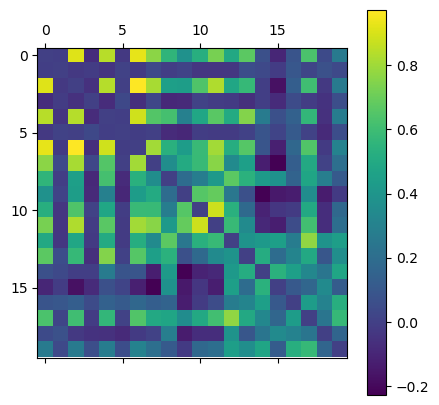

# node: 20  # edges: 135


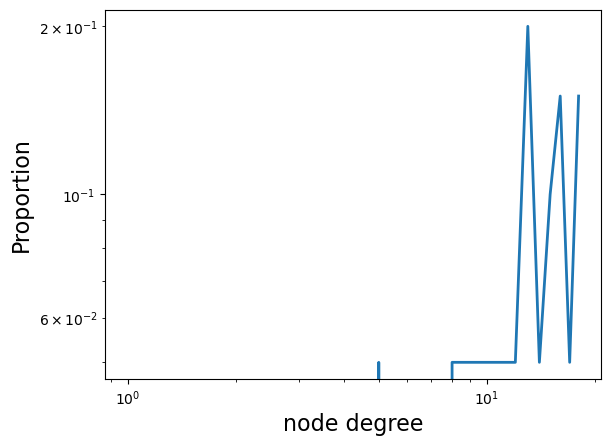

---- processing period  1  ----


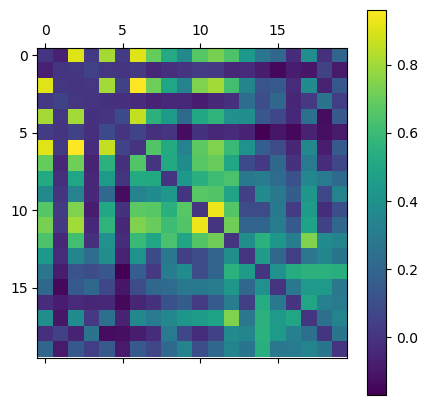

# node: 20  # edges: 140


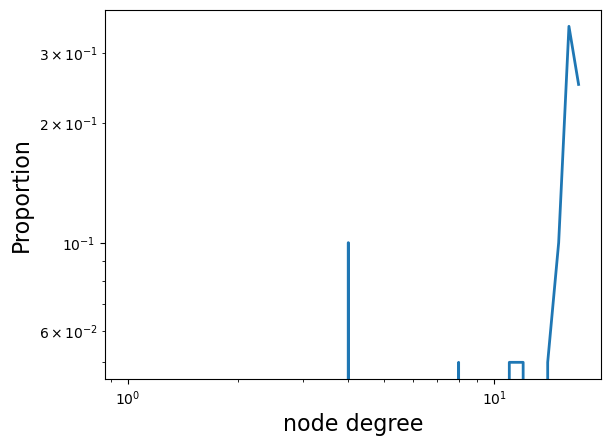

---- processing period  2  ----


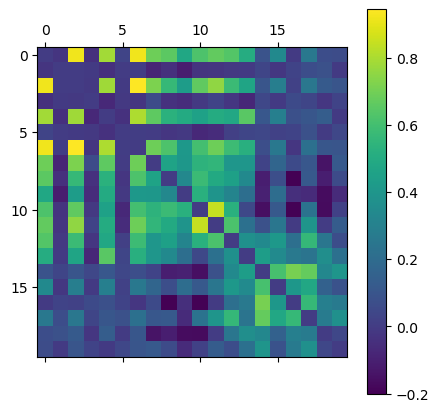

# node: 20  # edges: 139


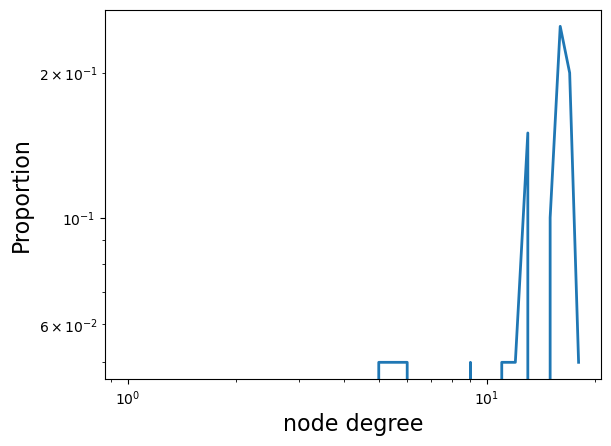

---- processing period  3  ----


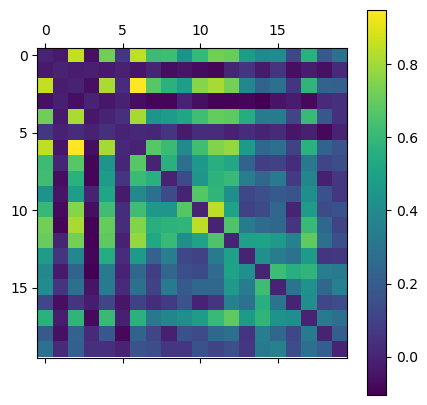

# node: 20  # edges: 139


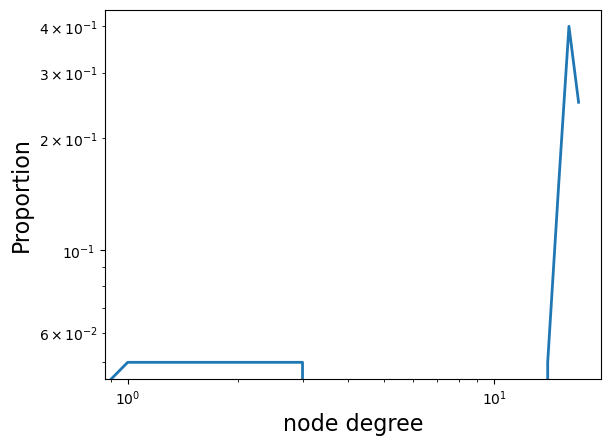

END


In [10]:
focus_regions = []
## Attention: Some brain regions of specified flies are not used.
if data_index in ['20230428-fly1', '20230510-fly1']:
    focus_regions = focus_regions_1
elif data_index == '20230507-fly1':
    focus_regions = focus_regions_2
else:
    focus_regions = focus_regions_0
    
period_cnt = 4
period_trails = 180 / period_cnt
whole_start_timepoint = 3
for period_i in range(period_cnt):
    print("---- processing period ", period_i, " ----")

    region_records_avg = []
    for region_idx in focus_regions:  
        # load record data
        records = np.load(path_output +'neuron_concat_records/region_' + str(region_idx) + '_neuron_records.npy',allow_pickle=True)

        ## select records for the given time period
        cnt = period_trails * period_i + 1 
        frames = 12
        duration = 23
        start_timepoint = whole_start_timepoint
        selected_data = records[:, start_timepoint : start_timepoint + frames]
        start_timepoint += duration
        len_max = len(records[0])
        while cnt < period_trails * (period_i + 1):
            cnt += 1
            selected_data = np.concatenate((selected_data, records[:, start_timepoint : start_timepoint + frames]), axis = 1) 
            start_timepoint += duration   

        # generate average records
        selected_data_avg = np.mean(selected_data, axis = 0)
        region_records_avg.append(selected_data_avg)
        
    '''
    generate functional connectivity matrix
    '''

    ## calculate pearson correlation matrix
    region_similarity_dict = {}
    n_regions = len(focus_regions)
    similarity = np.zeros((n_regions, n_regions))
    for i in range(n_regions - 1):
        for j in range(i + 1, n_regions):   
            pearson = pearsonr(region_records_avg[i], region_records_avg[j])
            similarity[i,j] = similarity[j,i] = pearson[0]
            pair = (focus_regions[i],focus_regions[j])
            region_similarity_dict[pair] = pearson[0]
    np.save(path_output + 'network/whole_brain_all_regions_similarity_preiod' + str(period_i) + '.npy', similarity)

    ## plot correlation matrix
    figure = plt.figure(figsize=(5,5)) 
    axes = figure.add_subplot(111) 
    caxes = axes.matshow(similarity, interpolation ='nearest') 
    figure.colorbar(caxes) 
    plt.savefig(path_output + 'network/whole_brain_all_regions_similarity_preiod' + str(period_i) + '.png')
    plt.show()

    '''
    generate functional connectivity network
    '''

    ## keep only correlations with high positive values 
    delete_seg = 0.3
    similarity_fla = similarity.flatten()
    similarity_fla.sort()
    threshold = similarity_fla[int(delete_seg * len(similarity_fla))]

    ## generate network from correlation matrix
    weighted_edges = [] 
    source = []
    target = []
    weight = []
    for i in range(len(similarity) - 1):
        for j in range(i + 1, len(similarity)):
            wei = np.round(similarity[i,j],4)
            if wei < threshold:
                continue
            weighted_edges.append(np.array([i,j,wei]))
            source.append(i)
            target.append(j)
            weight.append(wei)

    ## save network into csv files
    save_data_calc = {"source": source, "target": target, "weight": weight}
    df = pd.DataFrame(save_data_calc)
    df.to_csv(path_output + 'network/whole_brain_network_edges' + str(round(1 - delete_seg, 1)) + '_preiod' + str(period_i) + '.csv', index=False)

    '''
    calculate network statistics
    '''

    ## generate network  
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edges)

    ## network statistics
    n_nodes, n_edges = G.number_of_nodes(),G.number_of_edges()
    print("# node:",n_nodes, " # edges:", n_edges)
    degrees = nx.degree_histogram(G)
    x = range(len(degrees))
    y = [z / float(sum(degrees)) for z in degrees]
    plt.loglog(x,y, linewidth = 2)
    plt.xlabel("node degree", fontdict={'size': 16})
    plt.ylabel("Proportion", fontdict={'size': 16})
    plt.show()

    degree_assortativity = nx.degree_assortativity_coefficient(G)
    avg_clustering = nx.average_clustering(G)
    avg_shortest_path = 0
    diameter = 0
    try:
        avg_shortest_path = nx.average_shortest_path_length(G)
        diameter = nx.diameter(G)
    except:
        print('G is not connected!')
    density = nx.density(G)
    transitivity = nx.transitivity(G)
    d = dict(nx.degree(G))
    avg_degree = sum(d.values())/G.number_of_nodes()

    node_degrees = [round(i[1],3) for i in nx.degree(G,weight="weight")]
    node_degrees_avg = np.mean(node_degrees)
    node_degrees.sort(reverse = True)

    degree_centrality = [round(i,3) for i in nx.degree_centrality(G).values()]
    degree_centrality_avg = np.mean(degree_centrality)
    degree_centrality.sort(reverse = True)

    closeness_centrality = [round(i,3) for i in nx.closeness_centrality(G).values()]
    closeness_centrality_avg = np.mean(closeness_centrality)
    closeness_centrality.sort(reverse = True)

    betweenness_centrality = [round(i,3) for i in nx.betweenness_centrality(G).values()]
    betweenness_centrality_avg = np.mean(betweenness_centrality)
    betweenness_centrality.sort(reverse = True)

    ## save network statistics into csv files
    writer = pd.ExcelWriter(path_output +'network_stat/whole_brain_network_edges' + str(round(1 - delete_seg, 1)) + '_stat_preiod' + str(period_i) + '.xlsx')
    data_dict = {}
    data_dict["stats"] = ["nodes", "edges", "degree_assortativity", "avg_clustering", "avg_shortest_path", "density", 
                          "diameter", "transitivity", "avg_degree","n_degrees_mean", "n_degrees_mean_avg", 
                          "n_avg_degree_centrality", "n_avg_closeness_centrality", "n_avg_betweenness_centrality",
                          "n_degrees", "n_degree_centrality", "n_closeness_centrality",  "n_betweenness_centrality"]
    data_dict["values"] = [n_nodes, n_edges, round(degree_assortativity,3),round(avg_clustering,3),round(avg_shortest_path,3), 
                         round(density,3),diameter, round(transitivity,3), round(avg_degree,3),node_degrees_avg, 
                         round(node_degrees_avg/n_nodes,3), degree_centrality_avg,closeness_centrality_avg, 
                         betweenness_centrality_avg,node_degrees, degree_centrality, closeness_centrality, 
                         betweenness_centrality]
    df = pd.DataFrame(data_dict)
    df.to_excel(writer, sheet_name = "stat", index = False)        
    writer.save()

    whole_start_timepoint = start_timepoint

print("END")